In [41]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [43]:
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# dias_estada_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")

canasta_hospitalizados_grd = pd.read_excel(

    "../data/processed/canasta_procedimientos_hospitalizados.xlsx"
)

Primero se quiere hacer un forecasting total de los egresos (sin desglose por diagnostico),
y tambien de los procedimientos necesarios totales


In [44]:
DIAGNOSTICO = "C341"

In [45]:
resumen_egresos_totales = (
    egresos_torax.query("DIAG1 == @DIAGNOSTICO and ANO_EGRESO == 2019")
    .groupby(["ANO_EGRESO"])["n_egresos"]
    .sum()
    .reset_index()
)
resumen_procedimientos_totales = canasta_hospitalizados_grd.query(
    "DIAGNOSTICO1 == 'C34.1' and ANIO_EGRESO == 2019"
)

In [46]:
EGRESOS_AUMENTADOS = 300
EGRESOS_2019 = resumen_egresos_totales.n_egresos.iloc[0]
AUMENTO_PROPORCIONAL = EGRESOS_AUMENTADOS / EGRESOS_2019

In [47]:
procedimientos_aumentados = resumen_procedimientos_totales.copy()
COLS_A_AUMENTAR = ["cantidad_procedimientos", "cantidad_pacientes_distintos"]

procedimientos_aumentados[COLS_A_AUMENTAR] = (
    procedimientos_aumentados[COLS_A_AUMENTAR] * AUMENTO_PROPORCIONAL
)

# 1. Forecasting

En este cuadernilllo se quiere predecir la cantidad de egresos hospitalarios que tendra
el Hospital del Torax a lo largo del tiempo. Ademas, se quire saber cuantos insumos se necesitaran
para atender tales casos.

In [48]:
resumen_egresos = (
    egresos_torax.groupby(egresos_torax["FECHA_EGRESO"])["n_egresos"].sum().to_frame()
)

<Axes: xlabel='FECHA_EGRESO'>

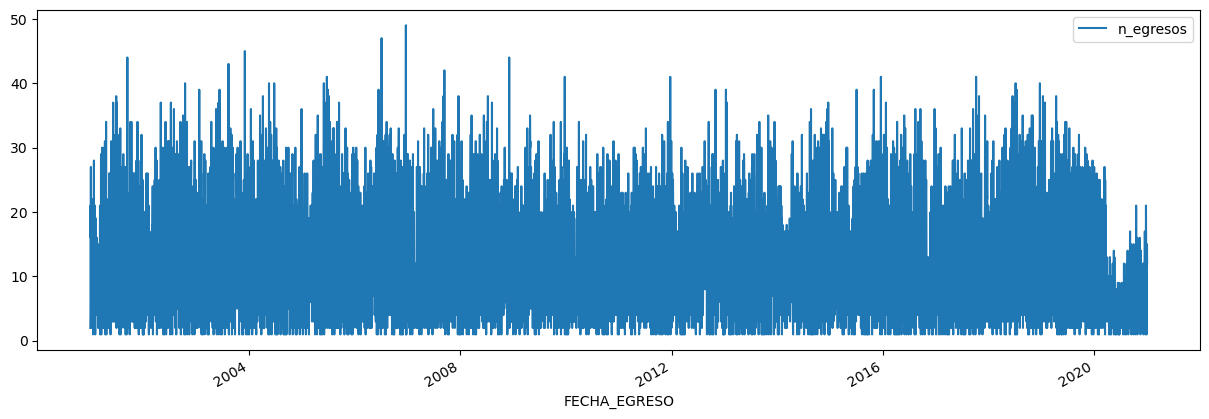

In [49]:
resumen_egresos.plot(figsize=(15, 5))

## Separacion en Train/Test

In [50]:
train = resumen_egresos[resumen_egresos.index < "01-01-2017"]
test = resumen_egresos[resumen_egresos.index >= "01-01-2017"]

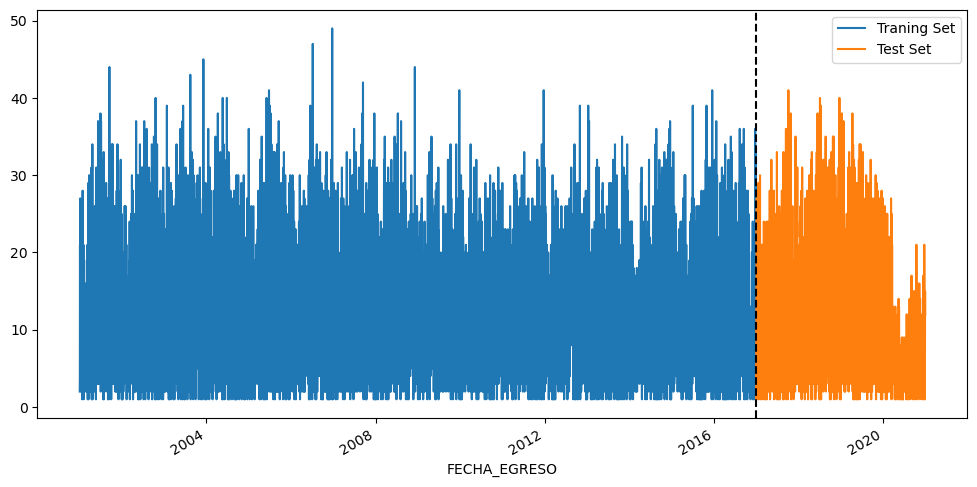

In [51]:
fig, axis = plt.subplots(1, 1, figsize=(12, 6))
train.plot(ax=axis, label="Traning")
test.plot(ax=axis, label="Test")
axis.axvline("01-01-2017", color="black", ls="--")
axis.legend(["Traning Set", "Test Set"])

In [52]:
resumen_egresos = build_features.create_features_datetime_index(resumen_egresos)

In [53]:
resumen_egresos

,n_egresos,dayofweek,quarter,month,year,dayofyear
FECHA_EGRESO,,,,,,
2001-01-01,2,0,1,1,2001,1
2001-01-02,4,1,1,1,2001,2
2001-01-03,21,2,1,1,2001,3
2001-01-04,16,3,1,1,2001,4
2001-01-05,27,4,1,1,2001,5
...,...,...,...,...,...,...
2020-12-27,1,6,4,12,2020,362
2020-12-28,4,0,4,12,2020,363
2020-12-29,7,1,4,12,2020,364


<Axes: xlabel='month', ylabel='n_egresos'>

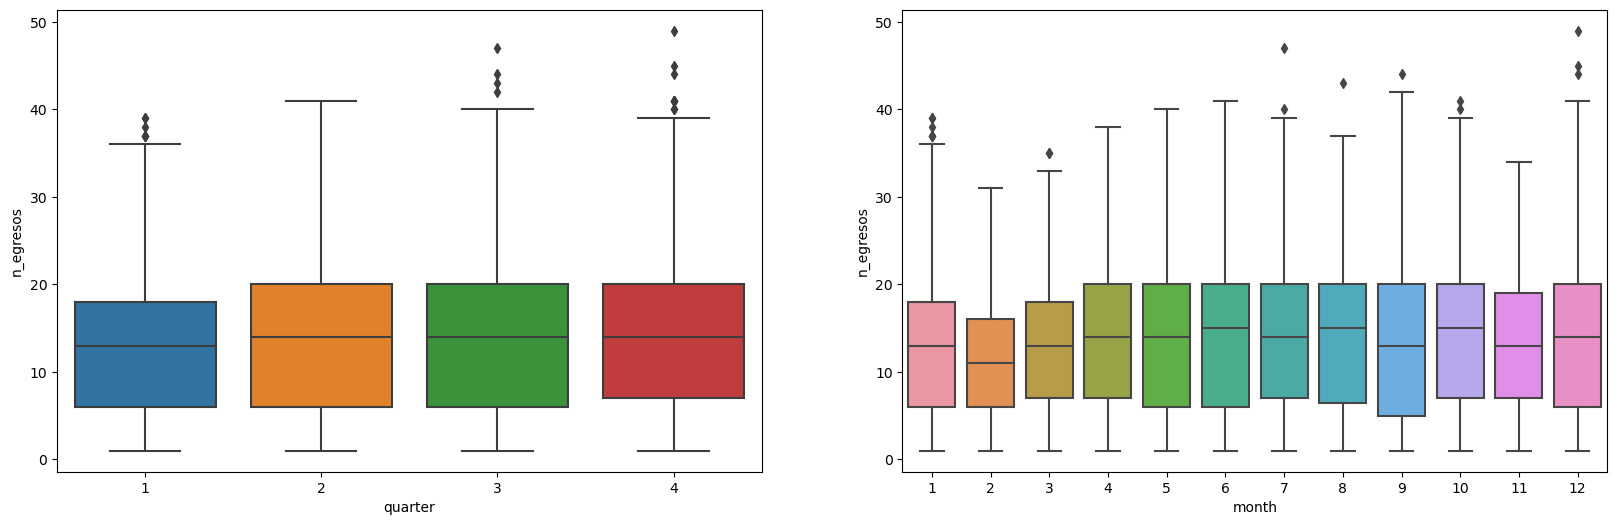

In [54]:
fig, axis = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(data=resumen_egresos, x="quarter", y="n_egresos", ax=axis[0])
sns.boxplot(data=resumen_egresos, x="month", y="n_egresos",ax=axis[1])

Con estos resultados se puede observar que en el primer cuatrimestre existe una menor cantidad
de egresos hospitalarios. Ademas, se aprecia que la distribucion de egresos por mes es similar
a lo largo de cada mes. Sin embargo, es posible apreciar que en el mes de febrero existe una
baja en el promedio de egresos.

# 3. Creacion de Modelo

In [55]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [56]:
train = build_features.create_features_datetime_index(train)
test = build_features.create_features_datetime_index(test)

FEATURES = ["dayofweek", "quarter", "month", "year", "dayofyear"]
TARGET = "n_egresos"

In [57]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [58]:
reg = XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

In [59]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:15.65424	validation_1-rmse:15.08315
[100]	validation_0-rmse:7.37489	validation_1-rmse:7.89197
[200]	validation_0-rmse:5.22667	validation_1-rmse:6.26352
[300]	validation_0-rmse:4.75007	validation_1-rmse:6.04094
[400]	validation_0-rmse:4.57068	validation_1-rmse:6.01762
[463]	validation_0-rmse:4.50394	validation_1-rmse:6.01784


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [60]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
)

<Axes: >

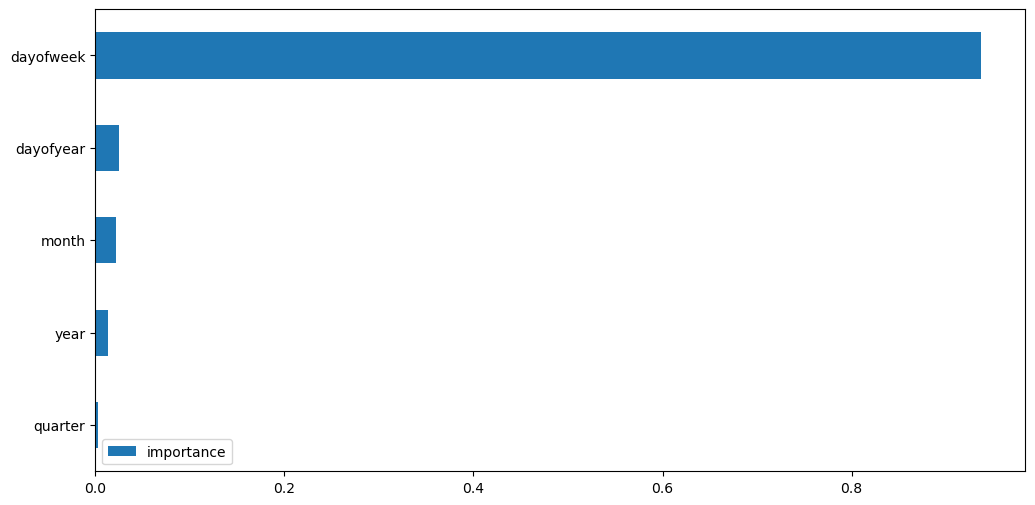

In [61]:
feature_importance.sort_values("importance").plot(kind="barh")

Estos resultados indican que el dia de la semana es altamente importante para predecir los egresos
hospitalarios!

## Prediccion en Test

In [62]:
test["prediction"] = reg.predict(X_test)

In [63]:
resumen_egresos = resumen_egresos.merge(
    test["prediction"], how="left", left_index=True, right_index=True
)

Text(0.5, 1.0, 'Data Real vs Prediccion de Egresos Hospitalarios INT')

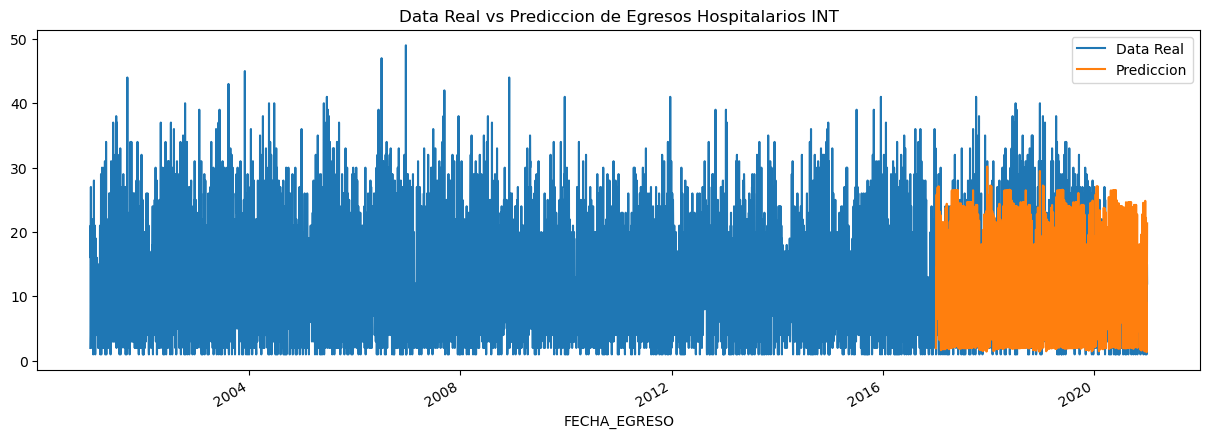

In [64]:
ax = resumen_egresos["n_egresos"].plot(figsize=(15, 5))
resumen_egresos["prediction"].plot(ax=ax)
plt.legend(["Data Real", "Prediccion"])
ax.set_title("Data Real vs Prediccion de Egresos Hospitalarios INT")

In [65]:
filtro_semana = resumen_egresos[
    (resumen_egresos.index >= "05-01-2017") & (resumen_egresos.index <= "05-08-2017")
]

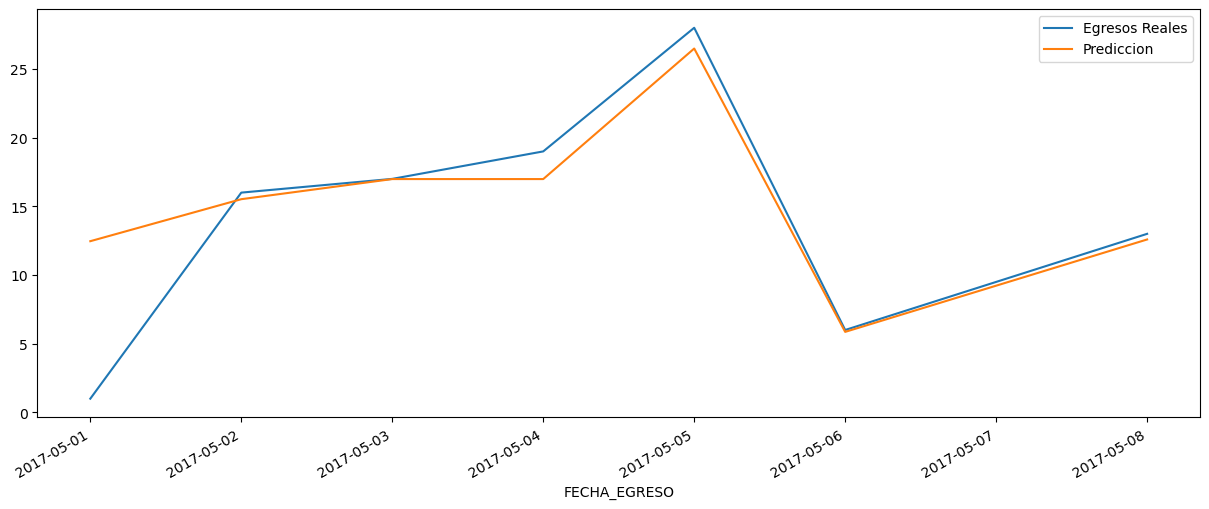

In [66]:
fig, axis = plt.subplots(figsize=(15, 6))
filtro_semana["n_egresos"].plot(ax=axis)
filtro_semana["prediction"].plot(ax=axis)
plt.legend(["Egresos Reales", "Prediccion"])

Y aca se puede ver la cantidad de egresos en la primera semana de Mayo de 2017.

In [67]:
rmse_modelo = np.sqrt(mean_squared_error(test["n_egresos"], test["prediction"]))
print(f"El modelo tiene un RMSE de: {rmse_modelo:0f} egresos")

El modelo tiene un RMSE de: 6.014391 egresos


In [68]:
test["error"] = np.abs(test["n_egresos"] - test["prediction"])

In [69]:
test.sort_values("error", ascending=False).head(5)

,n_egresos,dayofweek,quarter,month,year,dayofyear,prediction,error
FECHA_EGRESO,,,,,,,,
2020-05-01,2,4,2,5,2020,122,26.419123,24.419123
2020-06-05,3,4,2,6,2020,157,24.913717,21.913717
2017-10-26,38,3,4,10,2017,299,16.164009,21.835991
2019-04-19,5,4,2,4,2019,109,26.463892,21.463892
2020-06-19,3,4,2,6,2020,171,24.445564,21.445564


In [70]:
test.sort_values("error", ascending=False).tail(5)

,n_egresos,dayofweek,quarter,month,year,dayofyear,prediction,error
FECHA_EGRESO,,,,,,,,
2017-05-03,17,2,2,5,2017,123,16.986198,0.013802
2018-05-03,17,3,2,5,2018,123,16.986198,0.013802
2020-02-13,14,3,1,2,2020,44,13.989489,0.010511
2020-03-02,10,0,1,3,2020,62,10.007457,0.007457
2019-03-19,16,1,1,3,2019,78,16.003738,0.003738


<Axes: >

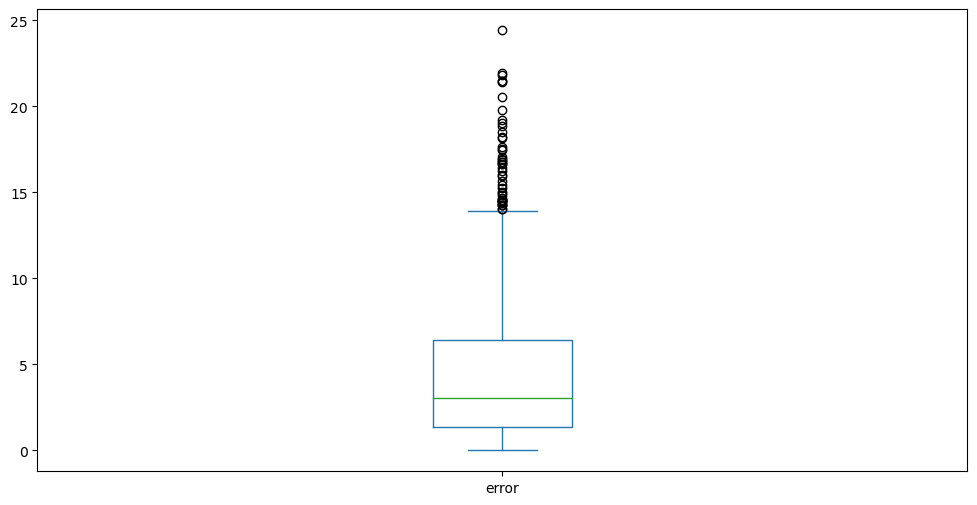

In [71]:
test["error"].plot(kind="box")

## Mejorando el modelo

Observamos que existen predicciones que tuvieron un error de hasta 26 egresos hospitalarios. Debido
a lo anterior, es necesario mejorar el modelo. Una de las formas mas efectivas de mejorar
el modelo es **remover outliers**!

## Remover Outliers

Se sabe que 2020 es un anio con grandes problemas (pandemia). Ademas, es posible observar una
disminucion significativa en la cantidad de egresos. Debido a esto, es necesario filtrar estos
anios.

In [72]:
resumen_egresos = resumen_egresos[resumen_egresos.index < "2020-01-01"]

Otra de las grandes mejores es hacer una validacion cruzada con las series de tiempo.

## Validacion Cruzada

In [74]:
from sklearn.model_selection import TimeSeriesSplit

In [78]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)
resumen_egresos = resumen_egresos.sort_index()

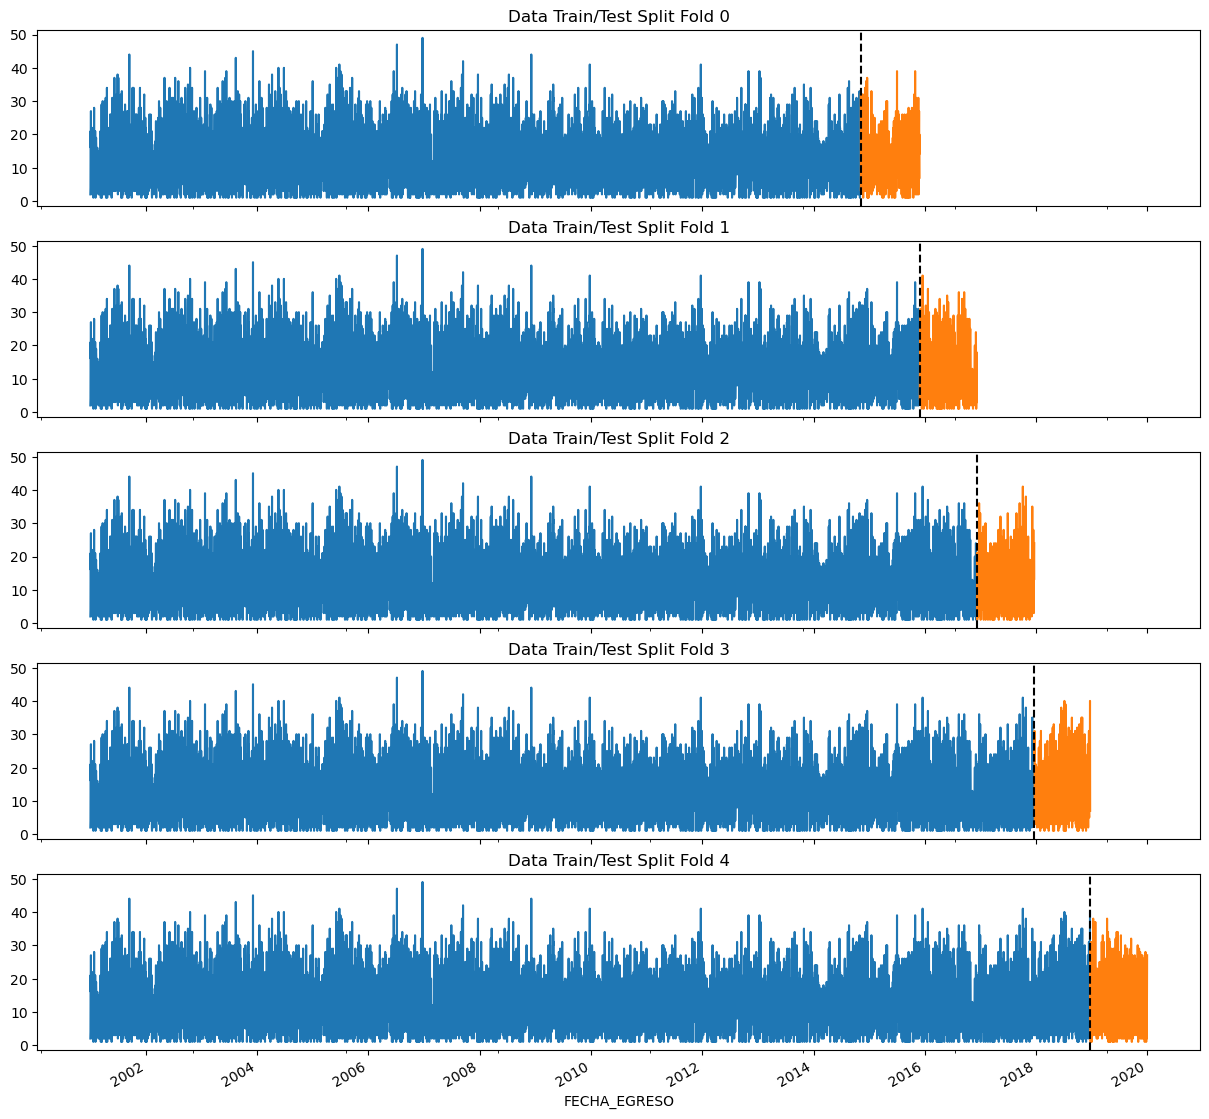

In [84]:
fig, axis = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(resumen_egresos):
    train = resumen_egresos.iloc[train_idx]
    test = resumen_egresos.iloc[val_idx]

    train["n_egresos"].plot(
        ax=axis[fold], label="Training", title=f"Data Train/Test Split Fold {fold}"
    )
    test["n_egresos"].plot(ax=axis[fold], label="Test Set")
    axis[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

In [80]:
train_idx

array([   0,    1,    2, ..., 4896, 4897, 4898])

In [81]:
val_idx

array([4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910,
       4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921,
       4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932,
       4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943,
       4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954,
       4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965,
       4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976,
       4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987,
       4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998,
       4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009,
       5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020,
       5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031,
       5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042,
       5043, 5044, 5045, 5046, 5047, 5048, 5049, 50

In [82]:
resumen_egresos

,n_egresos,dayofweek,quarter,month,year,dayofyear,prediction
FECHA_EGRESO,,,,,,,
2001-01-01,2,0,1,1,2001,1,NaN
2001-01-02,4,1,1,1,2001,2,NaN
2001-01-03,21,2,1,1,2001,3,NaN
2001-01-04,16,3,1,1,2001,4,NaN
2001-01-05,27,4,1,1,2001,5,NaN
...,...,...,...,...,...,...,...
2019-12-27,24,4,4,12,2019,361,18.414816
2019-12-28,7,5,4,12,2019,362,5.207456
2019-12-29,2,6,4,12,2019,363,2.528246
